 ------------
```{admonition} Learning Objectives
  - Understand band math principles using rioxarray and xarray operations
  - Calculate vegetation indices like NDVI and EVI using mathematical operations
  - Apply scaling factors to remotely sensed data for proper index calculations
  - Create custom spectral indices through band combinations
```
--------------


# Band Math & Vegetation Indices with Rioxarray

## Band Math Fundamentals
Band math involves combining spectral bands through mathematical operations to create new derived datasets that highlight specific features or phenomena. With rioxarray, these calculations are performed pixel-by-pixel using standard arithmetic operations. The output retains the same spatial extent and resolution as the input bands.

Here is a visual example of a band math operation combining three bands of data `b1`, `b2`, and `b3` to create a new single output. 

```{image} ../_static/f_rs/bandmath.gif
:alt: a visual example of a band math operation combining three bands of data b1, b2, and b3 to create a new single output.
Band math example
```

## Band Math with Rioxarray

Rioxarray DataArrays support all standard arithmetic operations, making band math operations straightforward and intuitive.

### Basic Arithmetic Operations
Standard mathematical operations can be performed between bands to create new derived products. For example, adding red and green bands can help highlight certain vegetation characteristics.

<xarray.DataArray (y: 1860, x: 2041)> Size: 8MB
array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [14775, 14312, 14244, ..., 14200, 14156, 14100],
       [14537, 14669, 14626, ..., 14139, 14098, 14140],
       [14440, 15029, 15108, ..., 14281, 14175, 14065]],
      shape=(1860, 2041), dtype=uint16)
Coordinates:
  * x            (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y            (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06
    spatial_ref  int64 8B 0


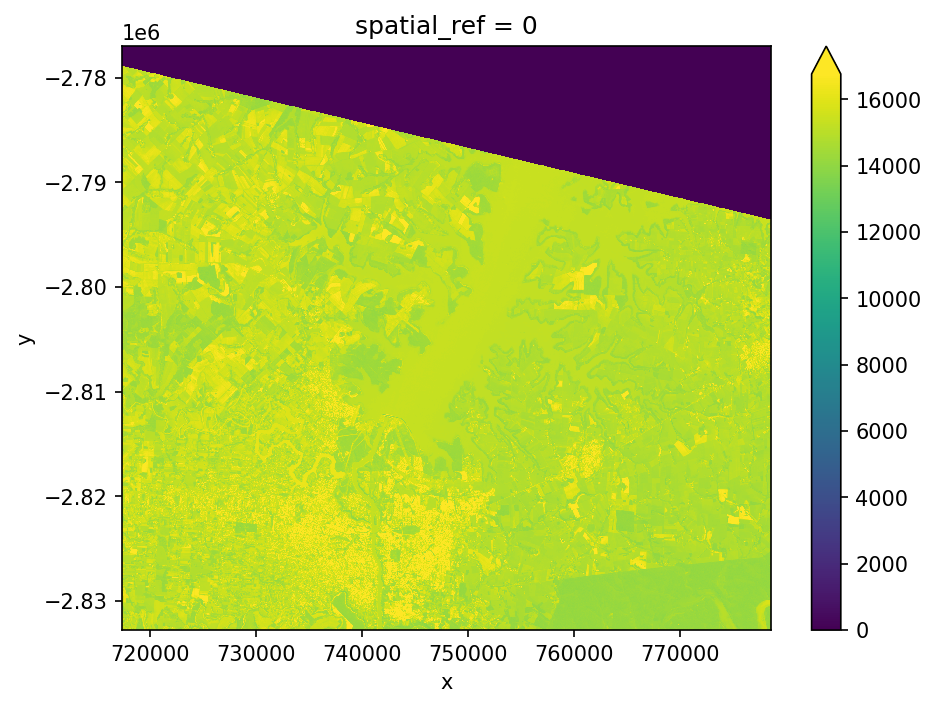

In [1]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path)
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    # Add NIR + Red (using green as NIR substitute)
    add_nir_red = src.sel(band='green') + src.sel(band='red')
    add_nir_red.plot(robust=True, ax=ax)
    print(add_nir_red)

plt.tight_layout(pad=1)

### Applying Scale Factors for Physical Units
Most satellite data requires scaling to convert digital numbers to physical units like reflectance. This example applies a common Landsat scale factor and creates a true-color composite.

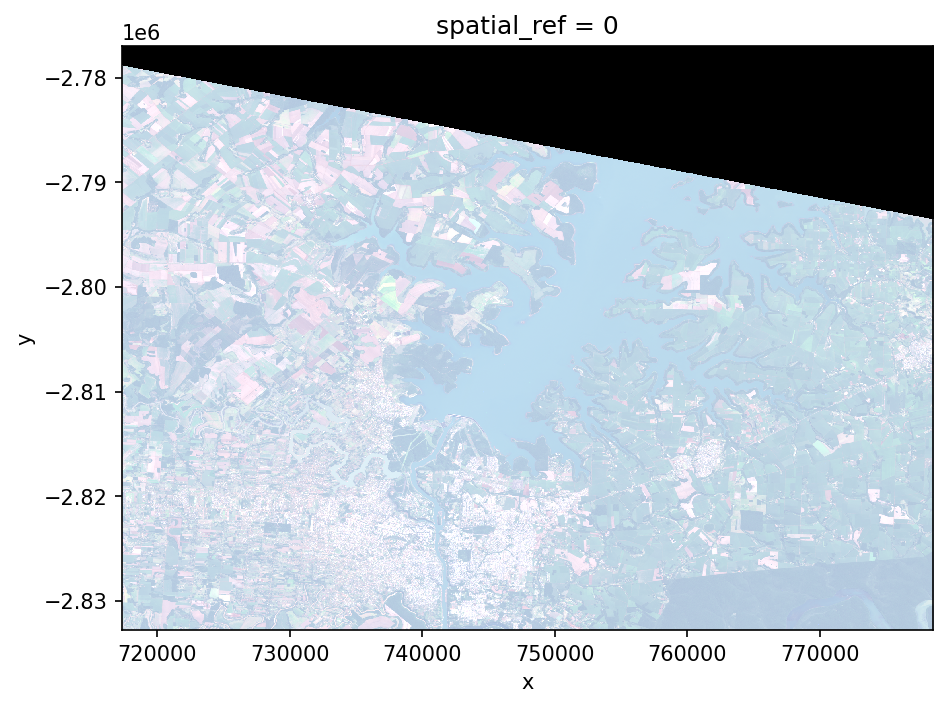

In [2]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path) * 0.0001
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    src.isel(band=[2, 1, 0]).plot.imshow(robust=True)

plt.tight_layout(pad=1)

## Vegetation Index Calculations
Vegetation indices exploit the unique spectral signature of healthy vegetation, which reflects strongly in near-infrared wavelengths while absorbing red light for photosynthesis. These indices provide quantitative measures of vegetation health, density, and phenological stage.

### Enhanced Vegetation Index (EVI)
EVI improves upon NDVI by incorporating a blue band correction and being less sensitive to atmospheric and soil background effects. The formula is:

$$EVI = G\times \frac{NIR-Red}{NIR+C_{1}\times Red-C_{2}\times Blue+L}$$

Where G=2.5, C₁=6, C₂=7.5, and L=1 are sensor-specific coefficients. EVI values range from -1 to +1, with higher values indicating healthier, denser vegetation.

In [3]:
import rioxarray as rxr

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
print(src)

# Calculate EVI manually (simplified for 3-band data)
if len(src.band) >= 3:
    src_scaled = src * 0.0001
    src_scaled = src_scaled.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    red = src_scaled.sel(band='red')
    green = src_scaled.sel(band='green')
    blue = src_scaled.sel(band='blue')
    
    # EVI formula: 2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)
    evi = 2.5 * (green - red) / (green + 6 * red - 7.5 * blue + 1)
    print(evi)

<xarray.DataArray (band: 3, y: 1860, x: 2041)> Size: 23MB
[11388780 values with dtype=uint16]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 16kB 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
  * y            (y) float64 15kB -2.777e+06 -2.777e+06 ... -2.833e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
<xarray.DataArray (y: 1860, x: 2041)> Size: 30MB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.11538462, -0.1157141 , -0.12173859, ..., -0.10500309,
        -0.10923566, -0.11324853],
       [-0.10386339, -0.09001867, -0.10238908, ..., -0.11448259,
        -0.11210554, -0.10999225],
       [-0.11151135, -0.085957

### Visualizing Vegetation Indices
Vegetation indices are typically displayed using color scales that emphasize the range of vegetation conditions, from stressed (low values) to healthy (high values).

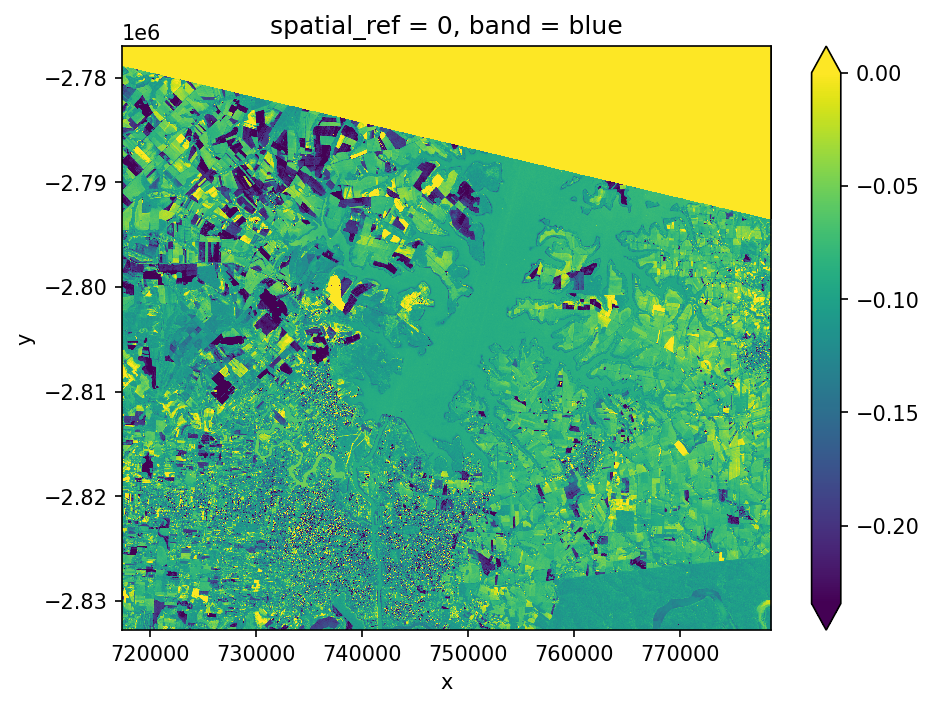

In [4]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path) * 0.0001
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    # Plot RGB
    src.isel(band=[2, 1, 0]).plot.imshow(robust=True)
    
    # Calculate and plot EVI
    red = src.sel(band='red')
    green = src.sel(band='green')
    blue = src.sel(band='blue')
    evi = 2.5 * (green - red) / (green + 6 * red - 7.5 * blue + 1)
    evi.plot(robust=True)

plt.tight_layout(pad=1)

### Two-band Enhanced Vegetation Index (EVI2)
EVI2 provides a simplified alternative to EVI that doesn't require a blue band, making it applicable to sensors without blue wavelength capability. The formula is: $G\times ((NIR-RED)/(L+NIR+C\times Red))$

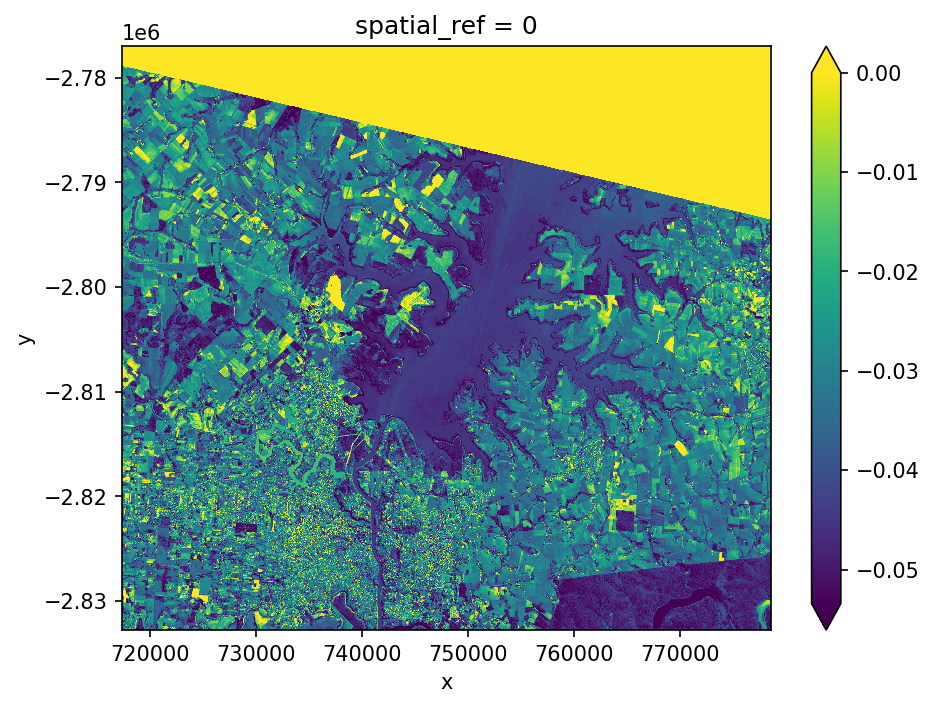

In [5]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path) * 0.0001
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    red = src.sel(band='red')
    green = src.sel(band='green')
    
    evi2 = 2.5 * (green - red) / (green + 2.4 * red + 1)
    evi2.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

### Two-band EVI Alternative Formula
This demonstrates the flexibility of vegetation index calculations, showing how coefficients can be adjusted for different sensors or research objectives.

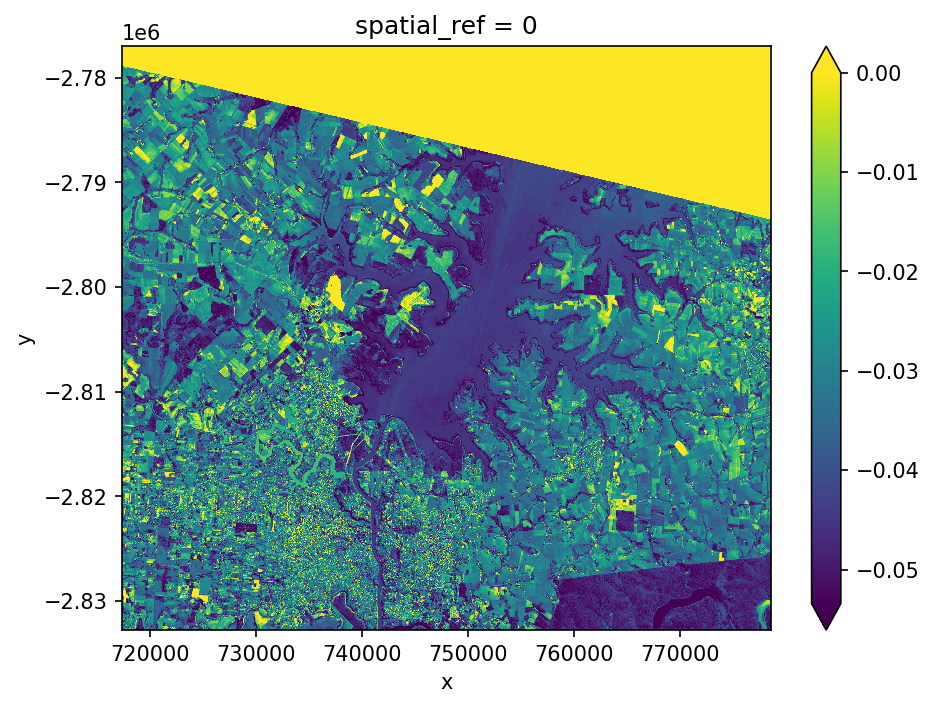

In [6]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path) * 0.0001
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    red = src.sel(band='red')
    green = src.sel(band='green')
    
    evi2 = 2.5 * (green - red) / (green + 2.4 * red + 1)
    evi2.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

### Normalized Difference Vegetation Index (NDVI)
NDVI is the most widely used vegetation index, calculated as the normalized difference between NIR and red reflectance: $\frac{NIR-Red}{NIR+Red}$. This simple ratio effectively separates vegetated from non-vegetated areas and provides information about vegetation density and health.

In [7]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path)
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    red = src.sel(band='red')
    green = src.sel(band='green')
    
    # NDVI: (NIR - Red) / (NIR + Red)
    ndvi = (green - red) / (green + red)
    ndvi.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

### Tasseled Cap Transformations
Tasseled Cap transformation applies linear combinations of spectral bands to create three new indices: brightness (overall reflectance), greenness (vegetation content), and wetness (soil and canopy moisture). This technique reduces multispectral data dimensionality while preserving key biophysical information.

In [8]:
import rioxarray as rxr
import matplotlib.pyplot as plt

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

fig, ax = plt.subplots(dpi=150)

src = rxr.open_rasterio(image_path) * 0.0001
if len(src.band) >= 3:
    src = src.assign_coords(band=['red', 'green', 'blue'][:len(src.band)])
    
    red = src.sel(band='red')
    green = src.sel(band='green')
    blue = src.sel(band='blue')
    
    # Simplified Tasseled Cap Wetness
    wetness = 0.1509 * blue + 0.1973 * green + 0.3279 * red
    
    print('bands', ['wetness'])
    wetness.plot(robust=True, ax=ax)

plt.tight_layout(pad=1)

bands ['wetness']


## Further Reading

For additional details, understanding, and in-depth explanations, consider exploring the following online resources:

- [Good list of Vegetation Index References](https://en.wikipedia.org/wiki/Vegetation_index)
- [Enhanced Vegetation Index (EVI)](https://en.wikipedia.org/wiki/Enhanced_vegetation_index)
- [Tasseled Cap Transformation](https://en.wikipedia.org/wiki/Tasseled_cap_transformation)
- [Normalized Difference Vegetation Index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)